### This notebook reproduces the urban accessibility map for Munich, from this tutorial:
https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56


## Steps
* Step 1: get the POIs for Munich, including GPS coordinates  
* Step 2: create Pandana network   
* Step 3: assign POIs, compute shortest distances
* Step 4: plot the shortest distances on the accesibility heatmap  


In [123]:
# libraries needed
import pandas as pd
import numpy as np

import pandana as pdna
import geopandas as gpd
import osmnx as ox

from shapely.geometry.polygon import Polygon
from shapely.geometry import box

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# to display plot in the notebook
%matplotlib inline


## Step 1: get the POIs for Munich

Get network map and POIs from the network

Use the documentation from here:
https://osmnx.readthedocs.io/en/stable/osmnx.html


In [82]:
# get a GeoDataFrame from Munich
place = ox.gdf_from_place('Munich, Germany')
bounds_city = place['geometry'][0].bounds
print(bounds_city)
# order bounds: 'east','north','south','west'
polygon_city = Polygon((list(box(bounds_city[0],bounds_city[1],bounds_city[2],bounds_city[3]).exterior.coords)))

(11.360777, 48.0616244, 11.7229083, 48.2481162)


In [83]:
# set POIs of interest
amenities = ['restaurant']
# other opions:
# 'hospital', 'clinic','cafe','school','bank','pharmacy','park']

In [84]:
# get POIs from Polygon
pois = ox.pois.pois_from_polygon(polygon_city, amenities)

print('Number of POIs')
print(len(pois))
print(pois[['amenity','name']].head())
# a long list of all the info about the POIs: (maybe useful in the future)
# print(list(pois.columns))

Number of POIs
2309
             amenity                       name
34034075  restaurant         Zum Goldenen Stern
34072038  restaurant        Franziskaner Garten
59933810  restaurant                    Goloseo
59933811  restaurant  Bistro Trattoria La Giara
59934326  restaurant                   L'angolo


In [ ]:
'''
# If we want to plot the network:
# city graph
G = ox.graph_from_address('Munich, Germany')
ox.plot_graph(G)
'''

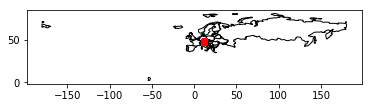

In [86]:

'''
# IF we want to plot the POIs on the map:
import matplotlib.pyplot as plt
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
pois.plot(ax=ax, color='red')
plt.show()
'''

Now we need to transform the addresses in GPS coordinates, because they are not available in the POIs data frame

### First test geocoding works with Nominatim (number of requests is limited)
If the next cell fails, a geocoding alternative to extract the coordinates from POI names may be needed.
A list of alternatives is here: https://wiki.openstreetmap.org/wiki/Search_engines  
Failed attempts (adddresses not recognized): 
* use Nominatim rate_limiter.RateLimiter to introduce delays and retries 
* geocoder Python: https://geocoder.readthedocs.io/  
* overpass API: https://wiki.openstreetmap.org/wiki/Overpass_API/Python_Wrapper  
Code not working on POI addersses   
import overpass  
api = overpass.API()  
response = api.get('node["name"="6 Gartenstadtstraße München DE"]')  
response['features'][0]['geometry']['coordinates'][0]  
  
Working but need to call from Python:  
* http://photon.komoot.de/  
* https://www.ideeslibres.org/GeoCheck/  

In [85]:
# basic test we can encode a location by address:
geolocator = Nominatim(user_agent="y")
location = geolocator.geocode("6 Gartenstadtstraße München DE")
print((location.latitude, location.longitude))

(48.1169479, 11.6702206)


In [91]:
import time
t1 = time.time()

pois['complete address'] = pois['addr:housenumber'] + ' ' + pois['addr:street'] + ' ' + pois['addr:city'] + ' ' + pois['addr:country']

# this takes long for all POIs (several minutes or more) (alternatively take less POIS
# limited to first 100 points for now
pois_test = pois.reset_index().loc[:100].copy()
def fct(x):
    try:
        location = geolocator.geocode(x)
    except:
        return np.nan
    return location
t2 = time.time()
pois_test['loc'] = pois_test['complete address'].apply(lambda x: fct(x))
print('time geocoding')
print(t2-t1)


0.03601193428039551


In [98]:
import datetime as dt
str(dt.datetime.now()).replace(':','').replace(' ','-').replace('.','-')

'2020-01-29-153629-253925'

In [100]:
print(pois_test.head())

# always cache geocoded addresses because there a limit per day: 
pois_test.to_pickle('pois_coord/' + str(dt.datetime.now()).replace(':','').replace(' ','-').replace('.','-') + '.pkl')

      index FIXME access addr:city addr:country addr:housename  \
0  34034075   NaN    NaN   München           DE            NaN   
1  34072038   NaN    NaN   München           DE            NaN   
2  59933810   NaN    NaN       NaN          NaN            NaN   
3  59933811   NaN    NaN       NaN          NaN            NaN   
4  59934326   NaN    NaN       NaN          NaN            NaN   

  addr:housenumber addr:postcode addr:state        addr:street  ...  \
0                6         81825        NaN  Gartenstadtstraße  ...   
1               45         81827        NaN  Friedenspromenade  ...   
2              NaN           NaN        NaN                NaN  ...   
3              NaN           NaN        NaN                NaN  ...   
4              NaN           NaN        NaN                NaN  ...   

  roof:levels roof:material roof:shape room rooms service_times website2  \
0         NaN           NaN        NaN  NaN   NaN           NaN      NaN   
1         NaN           

In [118]:
pois_test = pois_test.dropna(subset=['loc']).reset_index()

In [120]:
# extract coordinates
pois_test['lat'] = pois_test['loc'].apply(lambda x:x.latitude)
pois_test['lon'] = pois_test['loc'].apply(lambda x:x.longitude)
pois_test.loc[pois_test['complete address'].isnull(),'lat'] = np.NaN
pois_test.loc[pois_test['complete address'].isnull(),'lon'] = np.NaN
pois_test = pois_test[['name','lat','lon','complete address']].dropna()

In [133]:
# check coordinates fine:
pois_test.head()

,name,lat,lon,complete address
0,Zum Goldenen Stern,48.116948,11.670221,6 Gartenstadtstraße München DE
1,Franziskaner Garten,48.109315,11.670722,45 Friedenspromenade München DE
6,Ratskeller,48.137788,11.575344,8 Marienplatz München DE
7,Das Wirtshaus am Rathausplatz,48.065318,11.665420,2 Rathausplatz Ottobrunn DE
8,Ristorante Pattio D'oro,48.065590,11.662586,10 Putzbrunner Straße Ottobrunn DE


Keep the POIs for later, next create the Pandana network we want to compute the shortest paths on

## Step 2: create Pandana network, assign POIs, compute shortest distances

Create Pandana network, precomute, initiatilize, set POIs and calculate nearest POIs as in the tutorial:
https://udst.github.io/pandana/tutorial.html

First need to transform the nodes and edges from the shapefile to match the Pandana format: 
* extract x,y columns for coordinates
* extract weight column of edges
* make the nodes index int, from the osmid, by reseting the index of nodes and merging


### only run the next cell if no shape file already available

In [2]:
# reorder the bounds_city to match the funciton description: 
# from longitude min, latitude min, longitude max, latitude max to
# north, south, east, west

# this takes long! several minutes or longer
G = ox.graph_from_bbox(bounds_city[3], bounds_city[1], bounds_city[2], bounds_city[0], network_type='walk')
# get road network and save as .shp
ox.save_graph_shapefile(G, filename='sample', folder='data', encoding='utf-8')

### from here on run cells normally

In [124]:
nodes = gpd.read_file('data/sample/nodes/nodes.shp')
edges = gpd.read_file('data/sample/edges/edges.shp')

In [125]:
nodes['x'] = nodes['geometry'].apply(lambda x:x.coords[0][0])
nodes['y'] = nodes['geometry'].apply(lambda x:x.coords[0][1])
edges['weight'] = edges['length'].astype(float)
nodes['x'] = nodes['x'].astype(float)
nodes['y'] = nodes['y'].astype(float)

In [126]:
nodes['ix']=nodes.index
test  = pd.merge(nodes[['osmid','ix']].rename(columns={'osmid':'from','ix':'from_ix'}),edges,on='from')
test  = pd.merge(nodes[['osmid','ix']].rename(columns={'osmid':'to','ix':'to_ix'}),test,on='to')

In [127]:
net=pdna.Network(nodes["x"], nodes["y"], test["from_ix"], test["to_ix"],
                 test[["weight"]])

c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


## Step 3: calculate shortest distances to POIs 
(continue tutorial from here: https://udst.github.io/pandana/tutorial.html)


In [128]:
# check number of nodes in the network
net.node_ids

RangeIndex(start=0, stop=145731, step=1)

In [129]:
# this takes also some minutes
net.precompute(3000)

In [130]:
net.init_pois(1,2000,10)

In [131]:
net.set_pois("restaurants", pois_test['lon'], pois_test['lat'])

## Step 4: plot the shortest distances as accesibility heatmap

## Still need to debug!

accessiblity df are the distances from POIs to nearest restaurant

need to check why they are mostly = max distance (2000m)

In [134]:
# calculate distances 

#def plot_nearest_amenity(amenity,n,bbox=bbox):
distance=2000
num_pois = 1
amenity = 'restaurants'
n = 1

accessibility = net.nearest_pois(distance=distance, category=amenity, num_pois=num_pois)
print(accessibility)

                  1
0       2000.000000
1       2000.000000
2       2000.000000
3       2000.000000
4       2000.000000
5        812.453979
6       2000.000000
7       2000.000000
8       2000.000000
9       2000.000000
10      2000.000000
11      2000.000000
12      2000.000000
13      2000.000000
14      2000.000000
15      2000.000000
16      2000.000000
17      2000.000000
18      2000.000000
19      2000.000000
20      2000.000000
21      1761.202026
22      2000.000000
23      2000.000000
24      1715.571045
25      2000.000000
26      2000.000000
27      1485.468018
28      2000.000000
29      1741.991943
...             ...
145701  2000.000000
145702  2000.000000
145703  2000.000000
145704  1145.780029
145705  2000.000000
145706  2000.000000
145707  2000.000000
145708  2000.000000
145709  2000.000000
145710  2000.000000
145711  2000.000000
145712  2000.000000
145713  2000.000000
145714  2000.000000
145715  1144.676025
145716  2000.000000
145717  1008.299988
145718  2000.000000


(<mpl_toolkits.basemap.Basemap at 0x205e878bbe0>,
 <Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x205e877b160>)

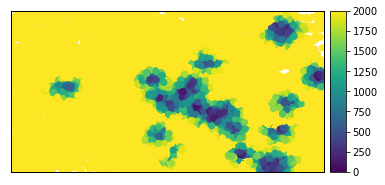

In [136]:
#print(box_muc)
#fig, ax = 
# net.plot(accessibility[n], bounds_city)
# important to rearrange the coordinates: 
net.plot(accessibility[n], [bounds_city[1],bounds_city[0],bounds_city[3],bounds_city[2]])
#ax.set_facecolor('k')
#ax.set_title('Pedestrian accessibility in Casablanca (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14)
 